<a href="https://colab.research.google.com/github/ruzcmc/ClickbaitIndo-textclassifier/blob/master/BERT_textclassification_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#huggingface
!pip install transformers
#SastrawiStemmer/StopwordsRemover
!pip install PySastrawi

!pip install -q pyyaml h5py

     |████████████████████████████████| 1.3MB 6.9MB/s 
     |████████████████████████████████| 1.1MB 23.6MB/s 
     |████████████████████████████████| 2.9MB 36.1MB/s 
     |████████████████████████████████| 890kB 33.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=ee1aa63662084929879c412f4f70cab3728e595035286c6cb4fd0305194e58da
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 215kB 7.0MB/s 


In [2]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from collections import Counter
from numpy import interp
import numpy as np
#from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from transformers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tqdm
import time
#from torch.utils.data import TensorDataset, random_split

from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.layers import Dense, Dropout,Embedding, LSTM, Bidirectional, Input, Dropout, GlobalAveragePooling1D, Flatten, Conv1D, GlobalMaxPooling1D
#from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import roc_curve, auc, confusion_matrix
#from tensorflow.keras.preprocessing import sequence

#import torch

# If there's a GPU available...
#if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
#    device = torch.device("cuda")

#    print('There are %d GPU(s) available.' % torch.cuda.device_count())

#    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
#else:
#    print('No GPU available, using the CPU instead.')
#    device = torch.device("cpu")

In [3]:
#LOAD DATASET
#training=pd.read_csv('https://raw.githubusercontent.com/ruzcmc/ClickbaitIndo-textclassifier/master/primary-dataset.csv')
#training=pd.read_csv('https://raw.githubusercontent.com/ruzcmc/ClickbaitIndo-textclassifier/master/clickid-main.csv')
trainingagree=pd.read_csv('https://raw.githubusercontent.com/ruzcmc/ClickbaitIndo-textclassifier/master/all_agree.csv')
#pd.options.display.max_colwidth=2000

trainingagree


#label_cols = ['text','label']

,title,label,label_score
0,"Masuk Radar Pilwalkot Medan, Menantu Jokowi Be...",non-clickbait,0
1,Malaysia Sudutkan RI: Isu Kabut Asap hingga In...,non-clickbait,0
2,Viral! Driver Ojol di Bekasi Antar Pesanan Mak...,clickbait,1
3,"Kemensos Salurkan Rp 7,3 M bagi Korban Kerusuh...",non-clickbait,0
4,MPR: Amandemen UUD 1945 Tak Akan Melebar ke Ma...,non-clickbait,0
...,...,...,...
8608,Twice Rilis Teaser MV 'Feel Special' Jelang Co...,clickbait,1
8609,"Asap Karhutla Riau Mulai Merambah Ke Nias, BM...",non-clickbait,0
8610,"Tolak RUU Pertanahan, Ribuan Petani Siap Gelar...",non-clickbait,0
8611,Ada Niat Tambah Momongan Tanpa Ikut Program Ha...,clickbait,1


3316
5297


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


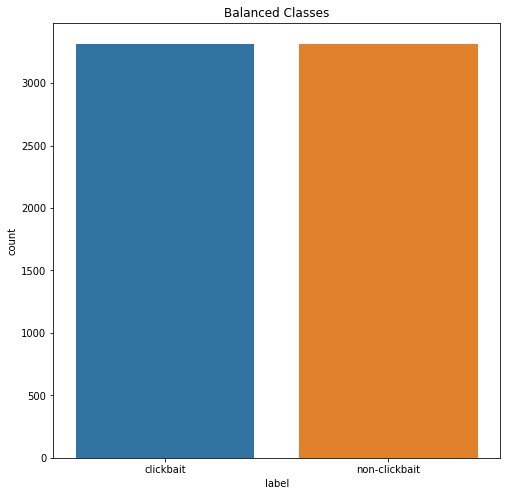

6632


In [5]:
# UNDERSAMPLE IF NEEDED
#ini yang kappa 1
clickbait = trainingagree.loc[trainingagree['label_score'] == 1]
print(len(clickbait))
nclickbait = trainingagree.loc[trainingagree['label_score'] == 0].sample(n=3316,random_state=22)
nclickbaitasli = trainingagree.loc[trainingagree['label_score'] == 0]
print(len(nclickbaitasli))
# Put all the fraud class in a separate dataset. ini yang kappa 0.4
#clickbait_df = training.loc[training['label_score'] == 1]
#print(len(clickbait_df))
#nclickbait_df = training.loc[training['label_score'] == 0].sample(n=6290,random_state=13)
#print(len(nclickbait_df))

#Randomly select 492 observations from the non-fraud (majority class)
#non_clickbait_df = training.loc[training['label'] == 0].sample(n=1393,random_state=42)

# Concatenate both dataframes again
normalized_df = pd.concat([clickbait, nclickbait])

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('label', data=normalized_df)
plt.title('Balanced Classes')
plt.show()

#print(normalized_df)
tags = normalized_df.label_score
texts = normalized_df.title
#print(tags)

#texts
print(len(texts))

In [6]:
#stemming INDO - no need with BERT TOkenizeR
#factory = StemmerFactory()
#stemmer= factory.create_stemmer()

#textstemss = []
textstem = []
textstemclick = []
textstemnon =[]
#for line in texts:
#  outstem = stemmer.stem(line)
#  textstemss.append(outstem)

#stopword remove
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()
for line in clickbait['title']:
  stop = stopword.remove(line)
  textstemclick.append(stop)
for line in nclickbait['title']:
  stopa = stopword.remove(line)
  textstemnon.append(stopa)


for line in texts:
  stop = stopword.remove(line)
  textstem.append(stop)  
  #hapus angka
#from string import digits

#for line in textstems:
#    remove_digits=str.maketrans(' ', ' ', digits)
#    result=line.translate(remove_digits)
#    textstem.append(result)


print(textstem)
#print(texts)

#X_train, X_test, y_train, y_test = train_test_split(textstem, tags, test_size=0.1, random_state=42)
#print(len(X_train))

['Viral! Driver Ojol Bekasi Antar Pesanan Makanan Pakai Sepeda', 'Ada Motor Nyangkut Atas Bambu Sleman, Kok Bisa?', 'Pesan Gamblang Poyuono Menolak Revisi UU KPK', 'Kocak! Maling Rumah Mewah Jakut Terekam CCTV Bingung Cari Jalan Kabur', 'Viral Video Diduga Baku Tembak Sleman, Ini Kata Polisi', 'Waspada! Ada Penipuan Catut Pertamina, Korbannya Rugi Puluhan Juta', 'Jaksa Beberkan Senpi-Peluru Tajam Pembelian Kivlan Zen cs, Ini Rinciannya', 'Sering Quality Time Bersama Keluarga? Ternyata Ini 3 Manfaatnya!', 'Menteri Jokowi 55% Profesional, Ini Kandidatnya?', "Pria Misterius Berjubah Putih Viral Sumut, Ingatkan 'Tuhan Murka'", 'Video Porno Sumedang Disebar Pemeran Pria, Apa Motifnya?', 'Terungkap! Video Porno Sumedang Diperankan Pasangan Selingkuh', 'Kendaraan Listrik Bebas Aturan Ganjil-Genap, Ini Alasannya', 'Menanti "Kebijakan Gila" Jokowi', 'Akhirnya! Pemkot Pekanbaru Liburkan SD SMP Kabut Asap', '2 Ribu Hektare Lahan Terbakar, Udara Palembang Tidak Sehat!', 'Viral Bocah Bekasi Disebut

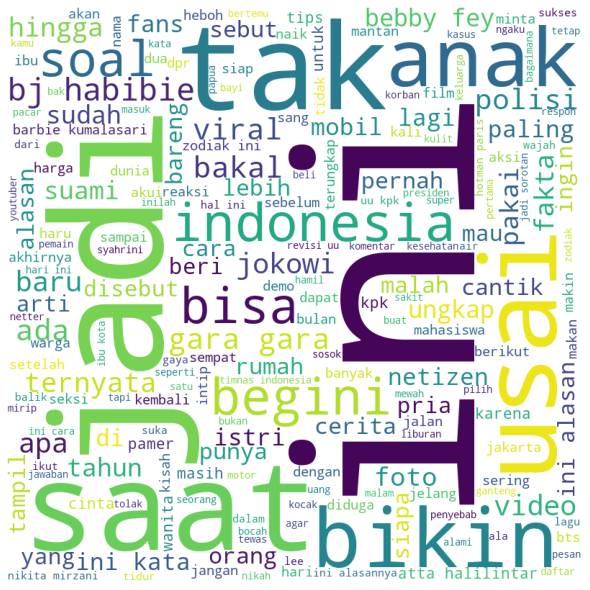

In [ ]:
#descriptive
from wordcloud import WordCloud, STOPWORDS 

  


comment_words = '' 

#in textstem  
# iterate through the csv file 
for val in textstemclick: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

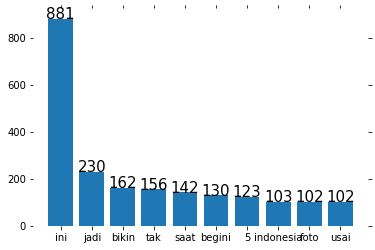

In [ ]:
#descriptive
# Create a list of words by converting to lowercase and splitting
kata = [s.lower().split() for s in textstemclick if s]
noline_ = [sublist for l in kata for sublist in l]
counts1 = dict(Counter(noline_).most_common(10))
labels1, values1 = zip(*counts1.items())

# sort your values in descending order
indSort1 = np.argsort(values1)[::-1]

# rearrange your data
labels1 = np.array(labels1)[indSort1]
values1 = np.array(values1)[indSort1]

indexes1 = np.arange(len(labels1))

bar_width = 1

mybar=plt.bar(indexes1, values1)
# get rid of the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# remove all the ticks and directly label each bar with respective value
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')

# plt.show()

# direct label each bar with Y axis values
for bari in mybar:
    height = bari.get_height()
    plt.gca().text(bari.get_x() + bari.get_width()/2, bari.get_height()-0.2, str(int(height)),
                 ha='center', color='black', fontsize=15)
# add labels
plt.xticks(indexes1, labels1)
#plt.savefig('/content/drive/My Drive/clickbait-textclassifier/top10words-NONclickbait.png')
plt.show()


In [ ]:
#TF x huggingface transformers
MAX_LEN = 22
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

def encodetext(sentence):
  input_ids = []
  attention_masks = []
  for sent in sentence:
      
      encoded_dict = tokenizer.encode_plus(
                          sent,                      
                          add_special_tokens = True,      # '[CLS]' and '[SEP]'
                          max_length = MAX_LEN,           
                          pad_to_max_length = True,       # Pad / truncate 
                          return_attention_mask = True,   # Construct attn. masks.
                          
                          return_token_type_ids=False     
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])
  return input_ids,attention_masks




In [ ]:
#tags = np.array(tags)
input_ids, attention_masks = np.array(encodetext(textstem))
print('Original: ', textstem[-5])
print('Token IDs:', input_ids[-5])
#print(normalized_df)
print(tags)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Polri-TNI Gelar Apel Pengamanan Jelang Unjuk Rasa DPR
Token IDs: [  101 14841 10425   118 64656 41780 86770 10159 79112 37806 10208 10149
 21525 10119 20982 34291 57474 10131   102     0     0     0]
2       1
8       1
10      1
30      1
37      1
       ..
731     0
2426    0
932     0
248     0
1371    0
Name: label_score, Length: 6632, dtype: int64


In [ ]:
#model definition
#custom model #keras Functional model
def createmodel():
  

  token_inputs = Input((MAX_LEN,), dtype=tf.int32, name='input_word_ids')
  mask_inputs = Input((MAX_LEN,), dtype=tf.int32, name='input_masks')
  

  bert_model = TFBertModel.from_pretrained("bert-base-multilingual-uncased")
  seq_output,_ = bert_model([token_inputs,mask_inputs])
  X = GlobalAveragePooling1D()(seq_output)
  X = Flatten()(X)
  X = Dense(100,activation='relu')(X)
  output_= Dense(1, activation='sigmoid', name='output')(X)

  bert_model2 = Model([token_inputs,mask_inputs],output_)
  return bert_model2

#HF model for Classification
def createhugmodel():
  bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased',num_labels=2)
  
  return bert_model



Running Fold 1 / 5


Some layers from the model checkpoint at bert-base-multilingual-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
332/332 [==============================] - 45s 134ms/step - loss: 0.3467 - accuracy: 0.8486
Epoch 2/5
332/332 [==============================] - 45s 134ms/step - loss: 0.1880 - accuracy: 0.9269
Epoch 3/5
332/332 [==============================] - 44s 134ms/step - loss: 0.1134 - accuracy: 0.9589
Epoch 4/5
332/332 [==============================] - 45s 134ms/step - loss: 0.0671 - accuracy: 0.9762
Epoch 5/5
332/332 [==============================] - 44s 134ms/step - loss: 0.0501 - accuracy: 0.9806
Confusion matrix
[[549 114]
 [ 29 635]]
              precision    recall  f1-score   support

           0       0.95      0.83      0.88       663
           1       0.85      0.96      0.90       664

    accuracy                           0.89      1327
   macro avg       0.90      0.89      0.89      1327
weighted avg       0.90      0.89      0.89      1327

accuracy: 89.22%
AUC
0.8921897999236766
Running Fold 2 / 5


Some layers from the model checkpoint at bert-base-multilingual-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
332/332 [==============================] - 45s 136ms/step - loss: 0.3091 - accuracy: 0.8711
Epoch 2/5
332/332 [==============================] - 45s 134ms/step - loss: 0.1477 - accuracy: 0.9467
Epoch 3/5
332/332 [==============================] - 45s 135ms/step - loss: 0.0808 - accuracy: 0.9723
Epoch 4/5
332/332 [==============================] - 45s 135ms/step - loss: 0.0458 - accuracy: 0.9815
Epoch 5/5
332/332 [==============================] - 45s 135ms/step - loss: 0.0205 - accuracy: 0.9932
Confusion matrix
[[625  39]
 [ 50 613]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       664
           1       0.94      0.92      0.93       663

    accuracy                           0.93      1327
   macro avg       0.93      0.93      0.93      1327
weighted avg       0.93      0.93      0.93      1327

accuracy: 93.29%
AUC
0.9329251394719148
Running Fold 3 / 5


Some layers from the model checkpoint at bert-base-multilingual-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
332/332 [==============================] - 45s 136ms/step - loss: 0.3082 - accuracy: 0.8630
Epoch 2/5
332/332 [==============================] - 45s 135ms/step - loss: 0.1353 - accuracy: 0.9485
Epoch 3/5
332/332 [==============================] - 45s 134ms/step - loss: 0.0739 - accuracy: 0.9719
Epoch 4/5
332/332 [==============================] - 45s 135ms/step - loss: 0.0321 - accuracy: 0.9889
Epoch 5/5
332/332 [==============================] - 45s 134ms/step - loss: 0.0221 - accuracy: 0.9925
Confusion matrix
[[615  48]
 [ 59 604]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       663
           1       0.93      0.91      0.92       663

    accuracy                           0.92      1326
   macro avg       0.92      0.92      0.92      1326
weighted avg       0.92      0.92      0.92      1326

accuracy: 91.93%
AUC
0.9193061840120663
Running Fold 4 / 5


Some layers from the model checkpoint at bert-base-multilingual-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
332/332 [==============================] - 45s 136ms/step - loss: 0.2969 - accuracy: 0.8739
Epoch 2/5
332/332 [==============================] - 45s 135ms/step - loss: 0.1277 - accuracy: 0.9527
Epoch 3/5
332/332 [==============================] - 45s 135ms/step - loss: 0.0725 - accuracy: 0.9746
Epoch 4/5
332/332 [==============================] - 45s 136ms/step - loss: 0.0326 - accuracy: 0.9876
Epoch 5/5
332/332 [==============================] - 45s 135ms/step - loss: 0.0231 - accuracy: 0.9921
Confusion matrix
[[612  51]
 [ 62 601]]
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       663
           1       0.92      0.91      0.91       663

    accuracy                           0.91      1326
   macro avg       0.91      0.91      0.91      1326
weighted avg       0.91      0.91      0.91      1326

accuracy: 91.48%
AUC
0.9147812971342383
Running Fold 5 / 5


Some layers from the model checkpoint at bert-base-multilingual-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
332/332 [==============================] - 45s 137ms/step - loss: 0.3208 - accuracy: 0.8643
Epoch 2/5
332/332 [==============================] - 45s 136ms/step - loss: 0.1565 - accuracy: 0.9448
Epoch 3/5
332/332 [==============================] - 45s 136ms/step - loss: 0.0809 - accuracy: 0.9721
Epoch 4/5
332/332 [==============================] - 45s 135ms/step - loss: 0.0482 - accuracy: 0.9832
Epoch 5/5
332/332 [==============================] - 46s 137ms/step - loss: 0.0322 - accuracy: 0.9891
Confusion matrix
[[626  37]
 [ 73 590]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       663
           1       0.94      0.89      0.91       663

    accuracy                           0.92      1326
   macro avg       0.92      0.92      0.92      1326
weighted avg       0.92      0.92      0.92      1326

accuracy: 91.70%
AUC
0.9170437405731523


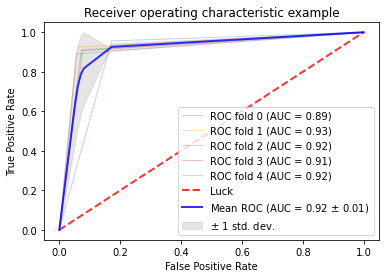

91.53% (+/- 1.31%)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 22)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 22)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 22, 768), (N 167356416   input_word_ids[0][0]             
                                                                 input_masks[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 768)          0           tf_

In [ ]:
#Kfold CrossVal


from sklearn.metrics import classification_report
n_folds = 5
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=13)
kfold = kfold.split(input_ids, y=tags)
cvscores = []
tprs = []
aucs = []

mean_fpr = np.linspace(0, 1, 100)

i = 0
opt = keras.optimizers.Adam(learning_rate=1e-05)
for i, (train, test) in enumerate(kfold):

  traindata = [input_ids[train],attention_masks[train]]
  testdata = [input_ids[test],attention_masks[test]]
  ytrain = tags.iloc[train]
  ytest = tags.iloc[test]

  
  print("Running Fold", i+1, "/", n_folds)
  
  bert_model2 = createmodel()

  bert_model2.compile(optimizer=opt,
              loss="binary_crossentropy",
              metrics=['accuracy'])
  bert_model2.fit(traindata, ytrain, epochs=5,verbose=1,batch_size=16)
  logits = bert_model2.predict(testdata)
  #print(logits) #kalo pake bert layer, ini ga usah tuple langsung aja
  predicts=(logits > 0.5).astype("int32")
  scores = bert_model2.evaluate(testdata, ytest, verbose=0)

  cm = confusion_matrix(ytest, predicts)
  creport = classification_report(ytest, predicts)
  print('Confusion matrix')
  print(cm)
  print(creport)
  print("%s: %.2f%%" % (bert_model2.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
    # Compute ROC curve and area the curve
  fpr, tpr, thresholds = roc_curve(ytest, predicts)
  tprs.append(interp(mean_fpr, fpr, tpr))
  tprs[-1][0] = 0.0
  roc_auc = auc(fpr, tpr)
  print('AUC')
  print(roc_auc)
  aucs.append(roc_auc)
  plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
  i += 1
  keras.backend.clear_session()

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
#plt.savefig('/content/drive/My Drive/clickbait-textclassifier/rocauc-BERT.png')
plt.show()

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

bert_model2.summary()

#print(seq_output)
#model.summary()
# Tell pytorch to run this model on the GPU. i gave up on pytorch this time. sorry
#model.cuda()

In [ ]:
#save Model for Production ^^

xtraining = [input_ids,attention_masks]
ytraining = tags
opt = keras.optimizers.Adam(learning_rate=1e-05)
bert_model2 = createmodel()

bert_model2.compile(optimizer=opt,
              loss="binary_crossentropy",
              metrics=['accuracy'])
bert_model2.fit(xtraining, ytraining, epochs=3,verbose=1,batch_size=16)
#bert_model2.save('/content/drive/My Drive/clickbait-textclassifier/BERT-IndoClickbaitClassifierMODEL.h5')

Epoch 1/3
175/175 [==============================] - 47s 271ms/step - loss: 0.4733 - accuracy: 0.7678
Epoch 2/3
175/175 [==============================] - 48s 272ms/step - loss: 0.3268 - accuracy: 0.8571
Epoch 3/3
175/175 [==============================] - 48s 272ms/step - loss: 0.2341 - accuracy: 0.9024


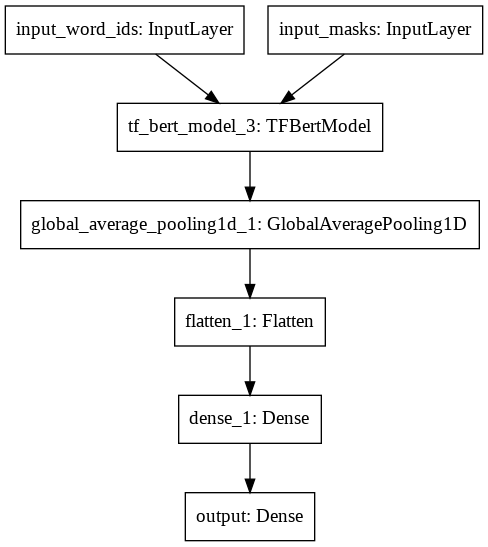

In [ ]:
keras.utils.plot_model(bert_model2, "/content/drive/My Drive/clickbait-textclassifier/BERTINDO.png")

In [ ]:
#manual testing
manualtest = pd.read_csv('https://raw.githubusercontent.com/ruzcmc/ClickbaitIndo-textclassifier/master/primary-dataset.csv')

#print(manualtest)
#manualtest.head()
manualtests = manualtest.text
tagtest = manualtest.label
#manualtests

In [ ]:
input_ids2, attention_masks2 = np.array(encodetext(manualtests))
print('Original: ', manualtests[0])
print('Token IDs:', input_ids2[0])
testdatamanual = [input_ids2,attention_masks2]

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Purnomo Serahkan Surat Mundur dari Pilkada  ke DPC PDIP Solo
Token IDs: [  101 27327 12883 10132 13796 24416 31431 26124 10131 10443 89449 66001
 11009 57474 10261 47843 25113 11174   102     0     0     0]


In [ ]:
xtraining = [input_ids,attention_masks]
ytraining = tags
opt = keras.optimizers.Adam(learning_rate=1e-05)
bert_test = createmodel()

bert_test.compile(optimizer=opt,
              loss="binary_crossentropy",
              metrics=['accuracy'])
bert_test.fit(xtraining, ytraining, epochs=5,verbose=1,batch_size=16)
#hasil = berttest.predict(testdatamanual)

Some layers from the model checkpoint at bert-base-multilingual-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
415/415 [==============================] - 57s 138ms/step - loss: 0.3300 - accuracy: 0.8602
Epoch 2/5
415/415 [==============================] - 57s 138ms/step - loss: 0.1776 - accuracy: 0.9331
Epoch 3/5
415/415 [==============================] - 57s 137ms/step - loss: 0.1157 - accuracy: 0.9558
Epoch 4/5
415/415 [==============================] - 57s 138ms/step - loss: 0.0723 - accuracy: 0.9718
Epoch 5/5
415/415 [==============================] - 57s 138ms/step - loss: 0.0457 - accuracy: 0.9839


Confusion matrix
[[1500  344]
 [ 214 1179]]
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1844
           1       0.77      0.85      0.81      1393

    accuracy                           0.83      3237
   macro avg       0.82      0.83      0.83      3237
weighted avg       0.83      0.83      0.83      3237

accuracy: 82.76%
AUC
0.8299118773290063


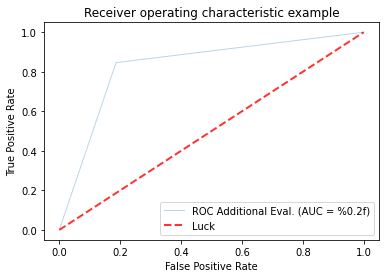

In [ ]:
#eval additional test
hasil = bert_test.predict(testdatamanual)
#print(logits) #kalo pake bert layer, ini ga usah tuple langsung aja
pred=(hasil > 0.5).astype("int32")
scores = bert_test.evaluate(testdatamanual, tagtest, verbose=0)

cm = confusion_matrix(tagtest, pred)
creport = classification_report(tagtest, pred)
print('Confusion matrix')
print(cm)
print(creport)
print("%s: %.2f%%" % (bert_test.metrics_names[1], scores[1]*100))
#cvscores.append(scores[1] * 100)
    # Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(tagtest, pred)
tprs.append(interp(mean_fpr, fpr, tpr))
tprs[-1][0] = 0.0
roc_auc = auc(fpr, tpr)
print('AUC')
print(roc_auc)
aucs.append(roc_auc)
plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC Additional Eval. (AUC = %0.2f)'% (i, roc_auc))


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Luck', alpha=.8)

#mean_tpr = np.mean(tprs, axis=0)
#mean_tpr[-1] = 1.0
#mean_auc = auc(mean_fpr, mean_tpr)
#std_auc = np.std(aucs)
#plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

#std_tpr = np.std(tprs, axis=0)
#tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
#tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
#plt.savefig('/content/drive/My Drive/clickbait-textclassifier/rocauc-BERT.png')
plt.show()


In [23]:
#COBA XGBOOST
def createxg():
  clf = xgb.XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7, verbosity=1, n_estimators=250)
  return clf


In [25]:
#tfidf vector

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer 
from sklearn.model_selection import cross_val_score
cv=CountVectorizer() 
 
# this steps generates word counts for the words in your docs 
wcvec=cv.fit_transform(textstem)
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(wcvec)

countvec = cv.transform(textstem)
tf_idf_vector=tfidf_transformer.transform(countvec)

#print(tf_idf_vector)

xbost = createxg()
#xbost.fit(tf_idf_vector,tags)


scores = cross_val_score(xbost, tf_idf_vector, tags, cv=10, verbose=1)
print('Accuracy for Tf-Idf & XGBoost Classifier : ', scores.mean())


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy for Tf-Idf & XGBoost Classifier :  0.8069804103290992


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   29.9s finished


In [ ]:
#berttest.save('/content/drive/My Drive/clickbait-textclassifier/BERT-IndoClickbaitClassifierMODEL.h5')

tf.keras.models.save_model(
    berttest,
    "/content/drive/My Drive/clickbait-textclassifier/BERT-IndoClickbaitClassifierMODEL.h5py",
    overwrite=False,
    include_optimizer=True
) 

INFO:tensorflow:Assets written to: /content/drive/My Drive/clickbait-textclassifier/BERT-IndoClickbaitClassifierMODEL.h5py/assets


In [ ]:
model2 = tf.keras.models.load_model("/content/drive/My Drive/clickbait-textclassifier/BERT-IndoClickbaitClassifierMODEL.h5py")

TypeError: ignored